Now trying SU(3) in the momentumbasis.

In [1]:
import numpy as np
import pandas as pd

# Setup plotting with matplotlib
import seaborn as sb
import matplotlib
import matplotlib.pyplot as plt
## setup latex plotting
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
## make font size bigger
matplotlib.rcParams.update({'font.size': 16})
## but make legend smaller
matplotlib.rcParams.update({'legend.fontsize': 14})
## change line thickness
matplotlib.rcParams.update({'lines.linewidth' : 1.75})

# SKLearn
from sklearn.manifold import TSNE

# Tensorflow Keras
# from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense
import tensorflow.keras.metrics as metrics
import tensorflow.keras.losses as losses
from tensorflow import one_hot 

from keras import backend as K
import tensorflow as tf

In [2]:
from sklearn.decomposition import PCA, FactorAnalysis
from sklearn.covariance import ShrunkCovariance, LedoitWolf
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV


n_components = np.arange(0, 8, 1)  # options for n_components

def compute_scores(X):
    pca = PCA(svd_solver='full')
    pca_scores = []
    for n in n_components:
        pca.n_components = n
        pca_scores.append(np.mean(cross_val_score(pca, X)))
    return pca_scores 

def shrunk_cov_score(X):
    shrinkages = np.logspace(-2, 0, 30)
    cv = GridSearchCV(ShrunkCovariance(), {'shrinkage': shrinkages})
    return np.mean(cross_val_score(cv.fit(X).best_estimator_, X))


def lw_score(X):
    return np.mean(cross_val_score(LedoitWolf(), X))


from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score


# Useful to find random orthogonal vectors
def find_orth(O):
    rand_vec = np.random.rand(O.shape[0], 1)
    A = np.hstack((O, rand_vec))
    b = np.zeros(O.shape[1] + 1)
    b[-1] = 1
    return np.linalg.lstsq(A.T, b)[0]

In [3]:
import random

def matprint(mat, fmt="g"):
    col_maxes = [max([len(("{:"+fmt+"}").format(x)) for x in col]) for col in mat.T]
    for x in mat:
        for i, y in enumerate(x):
            print(("{:"+str(col_maxes[i])+fmt+"}").format(y), end="  ")
        print("")
        
liststrucSU3 = np.array([[1,2,3,1],[1,4,7,.5],[1,5,6,-.5],[2,4,6,.5],[2,5,7,.5],[3,4,5,.5],[3,6,7,-.5],[4,5,8,3**0.5/2],[6,7,8,3**0.5/2]])
liststrucSU2 = np.array([[1,2,3,1],[3,2,1,1]])

def adjointSUN(dim,liststruc):
    dimSUN=dim**2-1
#     admat = np.zeros((8,8,8))
    admat = np.zeros((dimSUN,dimSUN,dimSUN))
    for i in range(liststruc.shape[0]):
        strucc = liststruc[i]
        strucc1 = int(strucc[0])-1
        strucc2 = int(strucc[1])-1
        strucc3 = int(strucc[2])-1
        admat[strucc1,strucc2,strucc3]=strucc[3]
        admat[strucc1,strucc3,strucc2]=-strucc[3]
        admat[strucc3,strucc1,strucc2]=strucc[3]
        admat[strucc3,strucc2,strucc1]=-strucc[3]
        admat[strucc2,strucc3,strucc1]=strucc[3]
        admat[strucc2,strucc1,strucc3]=-strucc[3]
    return admat

adjointSU3 = adjointSUN(3,liststrucSU3)

## Random potential values 

In [63]:
# import pandas as pd


# df_pions = pd.read_csv(r'data_su3_mombasis_1oct.csv')
# # df_pions = pd.read_csv(r'data_su3_mombasis_22sep.csv')
# print(df_pions[:5])
# # print(df_pions[-5:])

# df_pions_array = df_pions.values

# df_pions_array.shape

In [64]:
# ## Using the potential 
# Xs = df_pions_array[:,0:-2]
# Ys = (df_pions_array[:,-2])
# Ysnoonehot=np.copy(Ys)
# Ys_all=np.copy(Ys)
# Xs_all=np.copy(Xs)

# fig, axs = plt.subplots(2,8,figsize=(15,5))
# fig.tight_layout()

# # n, bins, patches = axs[2,0].hist(Ys,bins=100)

# for i in range(8):
#     n, bins, patches = axs[0,i].hist(Xs[:,i],bins=10)
#     n, bins, patches = axs[1,i].hist(Xs[:,i+8],bins=10)

In [65]:
# fig, axs = plt.subplots(1,figsize=(15,5))
# fig.tight_layout()
# axs.hist(Ys,bins=100)
# fig.tight_layout()

In [110]:
%%writefile getpotp.py

import random
import numpy as np
import scipy as sp
import chirallag as cL

N=3
gens = cL.gen_gellman(3)
F0 = 1

pirandbase=1+1*np.random.rand(8)
    

def getpotential(i):
    sp.random.seed()
    random_pi = -pirandbase*0.5+pirandbase*np.random.rand(8)
    random_p = (-1+2*np.random.normal(0,.1,8))
    random_dpi = random_pi*random_p

    potval = np.real(cL.get_V(random_pi,random_dpi,gens,F0))
    
    outp = np.hstack((random_p,random_pi,potval))
    
    return outp

Overwriting getpotp.py


In [111]:
import multiprocess as mp
from multiprocess import Pool
from tqdm import tqdm

import importlib
import loopygens 
import getpotp
importlib.reload(getpotp)
from getpot import getpotential

numit=10
number_predictions=100000


# frames_list = [cloudinput] * number_predictions
frames_list = [17] *number_predictions


len(frames_list)

max_pool = mp.cpu_count() 
# max_pool = 1

with Pool(max_pool) as p:
    pool_outputs = list(
        tqdm(
            p.imap(getpotential,
                   frames_list),
            total=len(frames_list)
        )
    )    

    
    
output=np.array(pool_outputs)


 63%|██████▎   | 62617/100000 [3:51:08<2:49:43,  3.67it/s] IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 73%|███████▎  | 72582/100000 [4:27:44<1:23:32,  5.47it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 82%|████████▏ | 82360/100000 [5:03:47<41:17,  7.12it/s]  IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variabl

In [136]:
np.savetxt("mombasis.csv", output, delimiter=",")

In [140]:
import pandas as pd
df_pions = pd.read_csv(r'mombasis.csv')
# print(df_pions[:5])

output = df_pions.values
output.shape


(99999, 17)

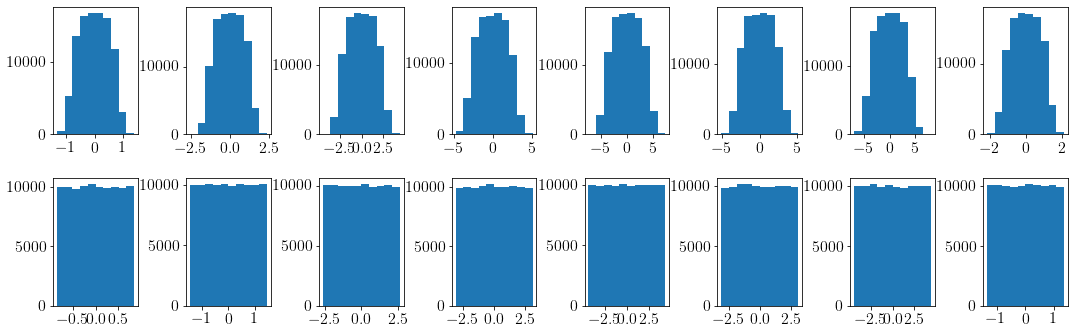

In [141]:
Xs = output[:,0:-1]
Ys = (-output[:,-1])**0.25

fig, axs = plt.subplots(2,8,figsize=(15,5))
fig.tight_layout()

# n, bins, patches = axs[2,0].hist(Ys,bins=100)

for i in range(8):
    n, bins, patches = axs[0,i].hist(Xs[:,i],bins=10)
    n, bins, patches = axs[1,i].hist(Xs[:,i+8],bins=10)

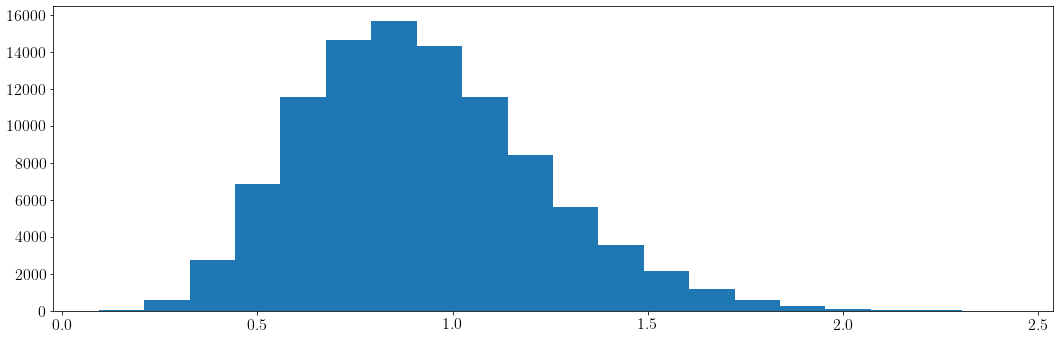

In [142]:
fig, axs = plt.subplots(1,figsize=(15,5))
fig.tight_layout()
axs.hist(Ys,bins=20)
fig.tight_layout()

# NN architecture

In [115]:
from IPython.display import clear_output
import ipywidgets as widgets

from tensorflow import keras
from keras.layers.advanced_activations import LeakyReLU
from tensorflow.keras import regularizers
from tensorflow.keras import layers


# Build in an automatic stop when no improvement is found, restore to best weights
callbackearlystop = tf.keras.callbacks.EarlyStopping(monitor='loss', baseline=None, patience=10, restore_best_weights = True)


class PlotLearning(keras.callbacks.Callback):
    """
    Callback to plot the learning curves of the model during training.
    
    """
        
    def on_train_begin(self, logs={}):
        self.metrics = {}
        for metric in logs:
            self.metrics[metric] = []
        

    def on_epoch_end(self, epoch, logs={}):
        # Storing metrics
        for metric in logs:
            if metric in self.metrics:
                self.metrics[metric].append(logs.get(metric))
            else:
                self.metrics[metric] = [logs.get(metric)]
        
        # Plotting
        metrics = [x for x in logs if 'val' not in x]
        f, axs = plt.subplots(1, len(metrics), figsize=(15,5))
        
        out = widgets.Output(layout={'border': '1px solid black'})
        clear_output(wait=True)
        
        with out:
            for i, metric in enumerate(metrics):
                axs[i].plot(range(1, epoch + 2), 
                            self.metrics[metric], 
                            label=metric
                           )
                axs[i].set_yscale('log')
                if logs['val_' + metric]:
                    axs[i].plot(range(1, epoch + 2), 
                                self.metrics['val_' + metric], 
    #                             label='val_' + metric
                               )

                axs[i].legend()
                axs[i].grid()

            for i, metric in enumerate(metrics):
                print("")
                print(self.metrics[metric][-1])

            
        plt.tight_layout()
        plt.show()


rlop = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=.2,
    patience=5,
    verbose=0,
    mode="auto",
    min_delta=0.0001,
    cooldown=0,
    min_lr=0,
)

# Build in an automatic stop when no improvement is found, restore to best weights
callbackearlystop = tf.keras.callbacks.EarlyStopping(monitor='loss', baseline=None, patience=10, restore_best_weights = True)

        
        
callbacks_list = [PlotLearning(),rlop]

In [116]:




# initializer = tf.keras.initializers.Constant(value=0.1)
initializer = tf.keras.initializers.VarianceScaling(scale=0.01, mode='fan_in', distribution='uniform')

activ = 'relu'
activ = 'elu'
activ = tf.keras.layers.LeakyReLU(alpha=0.3)
regu = regularizers.l1_l2(l1=1e-5, l2=1e-5)

inputs=tf.keras.Input(shape=Xs.shape[1])
x = tf.keras.layers.Dense(512, input_dim=Xs.shape[1], activation=activ, kernel_initializer=initializer)(inputs)
x = tf.keras.layers.Dense(512, activation=activ, kernel_initializer=initializer)(x)
x = tf.keras.layers.Dense(512, activation=activ, kernel_initializer=initializer)(x)
# x = tf.keras.layers.Dense(512, activation=activ, kernel_initializer=initializer)(x)
# # x = tf.keras.layers.Dense(8, activation=activ, kernel_initializer=initializer)(x)
# x = layers.Dropout(0.25)(x)
# x = tf.keras.layers.Dense(80, activation=activ, kernel_initializer=initializer, kernel_regularizer=regu)(x)
outputs = tf.keras.layers.Dense(1, activation=activ)(x) # use this for without one hot encoding
# outputs = tf.keras.layers.Dense(int(class_centers.shape[0]), activation=tf.keras.activations.linear)(x)
# outputs = tf.keras.layers.Dense(int(class_centers.shape[0]), activation='linear')(x)
modelrandom = tf.keras.Model(inputs=inputs,outputs=outputs)

modelrandom.summary()

Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 16)]              0         
_________________________________________________________________
dense_38 (Dense)             (None, 512)               8704      
_________________________________________________________________
dense_39 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_40 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_41 (Dense)             (None, 1)                 513       
Total params: 534,529
Trainable params: 534,529
Non-trainable params: 0
_________________________________________________________________


## Training 

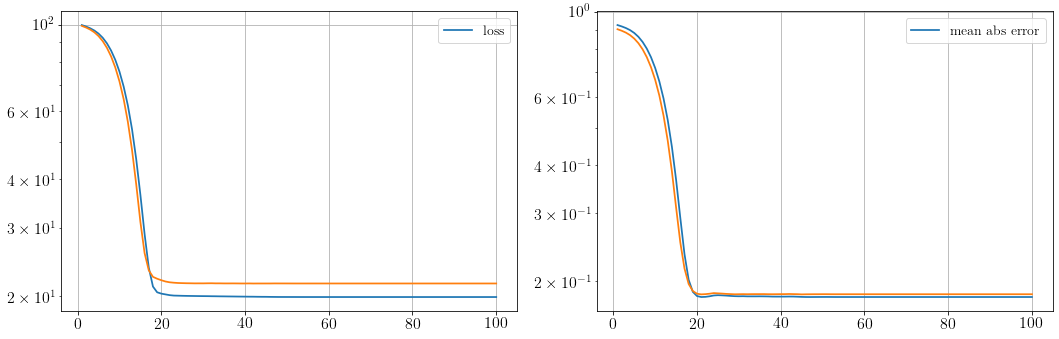

In [117]:
from sklearn.model_selection import train_test_split


Xsnew = Xs[:5000] 
Ysnew = Ys[:5000] 

# Without one hot encoding
sgdopt=tf.keras.optimizers.SGD(learning_rate=0.001, momentum=.1, nesterov=True, name='SGD')
adamopt=tf.keras.optimizers.Adam(learning_rate=1e-5, beta_1=0.9, beta_2=.99, epsilon=1e-8, amsgrad=True)
opt=adamopt
# modelrandom.compile(loss='mae',optimizer='sgd')
# model.compile(optimizer=sgdopt,loss='mape',metrics=[tf.keras.metrics.MeanAbsolutePercentageError(name='percentage error')])
# modelrandom.compile(optimizer=sgdopt,loss='mse',metrics=[tf.keras.metrics.MeanAbsolutePercentageError(name='percentage error')])

import tensorflow.keras.backend as kb
# def custom_loss(y_actual,y_pred):
#     delta=0.1
#     xtest=y_actual-y_pred
#     if xtest < delta:
#         custom_loss = 0.5*delta**2 + delta*(kb.abs(xtest)-delta)
#     else:
#         custom_loss = (0.5*kb.square(xtest))
# #     mask1 = kb.less(xtest, delta) #i.e. xtest < delta
# #     mask1 = tf.convert_to_tensor(mask1,dtype=tf.int32)
# #     mask2 = kb.less(delta, xtest) #i.e. xtest > delta
# #     mask2 = tf.convert_to_tensor(mask2,dtype=tf.int32)
#     return custom_loss

def custom_loss(y_actual,y_pred):
    delta= 1.2*y_pred/y_pred
    eps=1e-3
    yp=kb.pow(kb.abs(y_pred)+eps,delta)
    yt=kb.pow(kb.abs(y_actual)+eps,delta)
#     custom_loss = delta**(-1)*((yp- yt*kb.log(yp)) - (yt- yt*kb.log(yt)))
    custom_loss = kb.square(y_pred-y_actual) 
#     custom_loss = kb.abs((yp- delta*yt*kb.log(y_pred)) - (yt- delta*yt*kb.log(y_actual))) #+0.01*kb.abs(y_pred-y_actual)
#     custom_loss = kb.abs((yp- delta*yt*kb.log(y_pred))) #+0.01*kb.abs(y_pred-y_actual)
    return custom_loss


loss1 = tf.keras.losses.Huber(delta=0.01, name='huber_loss')
# loss1 = custom_loss
loss1 = 'mape'
modelrandom.compile(optimizer=opt,loss=loss1,
                    metrics=[tf.keras.metrics.MeanAbsoluteError(name='mean abs error')],run_eagerly=False)
# modelrandom.fit(Xsnew,Ysnew,epochs=3,batch_size=32,validation_split = 0.1,verbose=2,use_multiprocessing=True)

modelrandom.fit(Xsnew,Ysnew,epochs=100,batch_size=512,validation_split = 0.1,shuffle = True,
                verbose=0,use_multiprocessing=True, callbacks=callbacks_list)



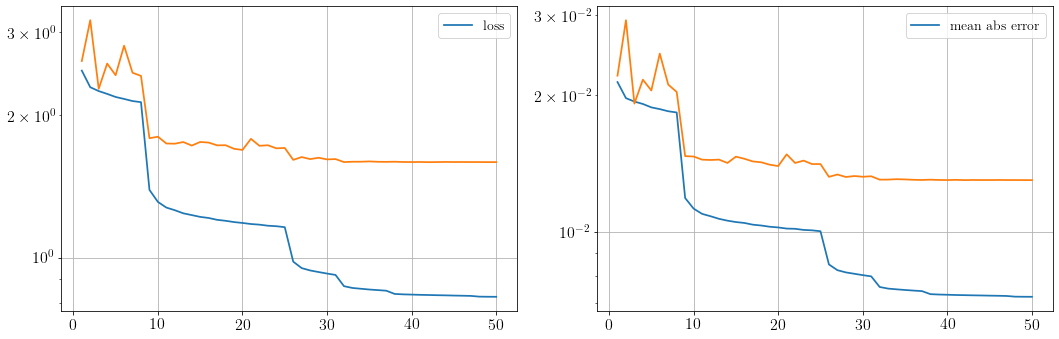

4


In [257]:
Xsnew = Xs[:] 
Ysnew = Ys[:] 

for i in range(5):
    print(i)
#     lrpow=(-2-i)
    lrpow = -3
    adamopt=tf.keras.optimizers.Adam(learning_rate=10**lrpow, beta_1=0.6, beta_2=.9, epsilon=1e-9, amsgrad=True)
    opt=adamopt

#     loss1='msle'
    loss1 = 'mape'

    modelrandom.compile(optimizer=opt,loss=loss1,
                        metrics=[tf.keras.metrics.MeanAbsoluteError(name='mean abs error')],run_eagerly=False)

    hist = modelrandom.fit(Xsnew,Ysnew,epochs=50,batch_size=16, shuffle = True,
                    validation_split = 0.05,verbose=0,use_multiprocessing=True, 
                    callbacks=callbacks_list)
    print(i)

In [11]:
# modelrandom.compile(optimizer=opt,loss='mae',metrics=[tf.keras.metrics.MeanSquaredError(name='mean sq error')],run_eagerly=False)

# modelrandom.fit(Xsnew,Ysnew,epochs=20000,batch_size=32,validation_split = 0.1,verbose=0,use_multiprocessing=True, callbacks=callbacks_list)

## Checking 

(please ignore)

In [122]:
# Check if it realises the symmetry by checking that an SU(3) transformation does not change the potential

eps=0.1
number_predictions=10

transVs=np.zeros(number_predictions)
transVdiffs=np.zeros(number_predictions)
randvecs=np.zeros((number_predictions,16))
randmeans=np.zeros(number_predictions)

for i in range(number_predictions):
    genno=random.randint(0, 7)
    random_vector = np.hstack((np.random.rand(8)*0.25,np.random.rand(8)))
    detgen=np.linalg.det(np.identity(8)+eps*adjointSU3[genno])
    trans_random_vector=detgen**-1*(random_vector+eps*np.hstack((np.matmul(adjointSU3[genno],
                                                   random_vector[:8]),np.matmul(adjointSU3[0],random_vector[8:]))))
    random_vector=np.reshape(random_vector,(1,-1))
    trans_random_vector=np.reshape(trans_random_vector,(1,-1))
    
    random_V = (modelrandom.predict(random_vector))**4
    trans_random_V = (modelrandom.predict(trans_random_vector))**4
    
    transVs[i]=random_V
    transVdiffs[i]=random_V - trans_random_V
    randvecs[i]=random_vector
    randmeans[i]=np.mean(np.abs(random_vector))

print(np.mean(np.abs(transVs)))
print(np.mean(np.abs(transVdiffs)))
print(np.mean(randmeans))

0.7952922999858856
0.03820186406373978
0.3181345908217151


In [13]:
# Check that it DOES NOT REALISE SO(8) symmetry by checking a transformation 

eps=0.1
number_predictions=100

transVs=np.zeros(number_predictions)
transVdiffs=np.zeros(number_predictions)
randvecs=np.zeros((number_predictions,16))
randmeans=np.zeros(number_predictions)

for i in range(number_predictions):
    genno1=random.randint(0, 7)
    genno2=random.randint(0, 7)
    rotesamp=np.zeros((8,8))
    rotesamp[genno1,genno2]=1
    rotesamp[genno2,genno1]=-1

    random_vector = np.hstack((np.random.rand(8)*0.25,np.random.rand(8)))
    detgen=np.linalg.det(np.identity(8)+eps*rotesamp)
    trans_random_vector=detgen**-1*(random_vector+eps*np.hstack((np.matmul(rotesamp,
                                                   random_vector[:8]),np.matmul(rotesamp,random_vector[8:]))))
    random_vector=np.reshape(random_vector,(1,-1))
    trans_random_vector=np.reshape(trans_random_vector,(1,-1))
    
    random_V = (modelrandom.predict(random_vector))**4
    trans_random_V = (modelrandom.predict(trans_random_vector))**4
    
    transVs[i]=random_V
    transVdiffs[i]=random_V - trans_random_V
    randvecs[i]=random_vector
    randmeans[i]=np.mean(np.abs(random_vector))

print(np.mean(np.abs(transVs)))
print(np.mean(np.abs(transVdiffs)))
print(np.mean(randmeans))

87.56028294563293
11.518803799152375
0.31382993814818255


In [14]:
# Check that it DOES NOT REALISE SO(8) symmetry by checking a transformation 

eps=0.1
number_predictions=100

transVs=np.zeros(number_predictions)
transVdiffs=np.zeros(number_predictions)
rotVdiffs=np.zeros(number_predictions)
randvecs=np.zeros((number_predictions,16))
randmeans=np.zeros(number_predictions)

for i in range(number_predictions):
    
    random_vector = np.hstack((np.random.rand(8)*0.25,np.random.rand(8)))
    
#     Random rotation
    rotno1=random.randint(0, 7)
    rotno2=random.randint(0, 7)
    rotesamp=np.zeros((8,8))
    rotesamp[rotno1,rotno2]=1
    rotesamp[rotno2,rotno1]=-1
    detrot=np.linalg.det(np.identity(8)+eps*rotesamp)
    rot_random_vector=detrot**-1*(random_vector+eps*np.hstack((np.matmul(rotesamp,
                                                   random_vector[:8]),np.matmul(rotesamp,random_vector[8:]))))
#     Random transfromation under SU(3) adjoint
    genno=random.randint(0, 7)
    detgen=np.linalg.det(np.identity(8)+eps*adjointSU3[genno])
    trans_random_vector=detgen**-1*(random_vector+eps*np.hstack((np.matmul(adjointSU3[genno],
                                                   random_vector[:8]),np.matmul(adjointSU3[0],random_vector[8:]))))
    
    random_vector=np.reshape(random_vector,(1,-1))
    trans_random_vector=np.reshape(trans_random_vector,(1,-1))
    rot_random_vector=np.reshape(rot_random_vector,(1,-1))
    
    random_V = (modelrandom.predict(random_vector))**4
    rot_random_V = (modelrandom.predict(rot_random_vector))**4
    trans_random_V = (modelrandom.predict(trans_random_vector))**4
    
    transVs[i]=random_V
    transVdiffs[i]=(random_V - trans_random_V)/random_V
    rotVdiffs[i]=(random_V - rot_random_V)/random_V
    randvecs[i]=random_vector
    randmeans[i]=np.mean(np.abs(random_vector))

    
print("Average normalised error of SU(3) transformation: ",np.mean(np.abs(transVdiffs)),
      ", and of rotation: ",np.mean(np.abs(rotVdiffs)))

print("Average potential value: ",np.mean(np.abs(transVs)),", average pion value:",np.mean(randmeans))

Average normalised error of SU(3) transformation:  0.15903826445690356 , and of rotation:  0.12588164904504084
Average potential value:  83.33108180731534 , average pion value: 0.3175546547708111


## Error with epsilon 

In [246]:
# Checking scaling with epsilon of transformations


number_predictions=1000

transVs=np.zeros(number_predictions)
epses=np.zeros(number_predictions)
transVdiffs=np.zeros(number_predictions)
rotVdiffs=np.zeros(number_predictions)
shiftVdiffs=np.zeros(number_predictions)

randvecs=np.zeros((number_predictions,16))
randmeans=np.zeros(number_predictions)

lastloss= np.log10((hist.history)['val_loss'][-1]*0.01)

for i in range(number_predictions):
    
    print(i)
    clear_output(wait=True)
    
    if i < 9*number_predictions/10:
        eps=10**(2*round(random.uniform(0.25*lastloss,0.25),1))
    else:
        eps=10**(2*round(random.uniform(0.25*lastloss-0.5,0.25*lastloss),1))
#     eps=10**(2*round((-1.*random.random()+0.25),1))
    
    random_vector = Xs[random.randint(0, Xs.shape[0]),:]
#     random_vector = df_pions_array[random.randint(0, 10000),0:-2]
    
#     Random rotation
    rotno1=random.randint(0, 7)
    rotno2=random.randint(0, 7)
    while rotno2 == rotno1:
        rotno2=random.randint(0, 7)
    rotesamp=np.zeros((8,8))
    rotesamp[rotno1,rotno2]=1
    rotesamp[rotno2,rotno1]=-1
    detrot=1
#     detrot=2*np.trace(np.matmul(rotesamp,rotesamp))
#     detrot=np.linalg.det(np.identity(8)+eps*rotesamp)
    rot_random_vector=detrot**-1*(random_vector+eps*np.hstack((np.matmul(rotesamp,
                                                   random_vector[:8]),np.matmul(rotesamp,random_vector[8:]))))
#     Random transfromation under SU(3) adjoint
    genno=random.randint(0, 7)
    detgen=1
    
    su3trans = adjointSU3[genno]
#     su3trans = 0
#     for ii in range(7):
#         su3trans += 0.25*random.random()*adjointSU3[ii]

#     detgen=np.linalg.det(np.identity(8)+eps*adjointSU3[genno])
#     detgen=2*np.trace(np.matmul(adjointSU3[1],adjointSU3[1]))
    trans_random_vector=detgen**-1*(random_vector+eps*np.hstack((np.matmul(su3trans,
                                                   random_vector[:8]),np.matmul(su3trans,random_vector[8:]))))
    
    #     Random shift of the pion field (not of momenta)
    shiftby = random.random()
    randompi = random.randint(0, 7)
    random_shift = np.zeros((8,8))
    random_shift[randompi,randompi] = shiftby
    shift_random_vector=(random_vector+eps*np.hstack((0*random_vector[:8],
                                                      np.matmul(random_shift, random_vector[8:]/random_vector[8:]))))
#                                                       np.matmul(random_shift, random_vector[8:]))))
    
    random_vector=np.reshape(random_vector,(1,-1))
    trans_random_vector=np.reshape(trans_random_vector,(1,-1))
    rot_random_vector=np.reshape(rot_random_vector,(1,-1))
    shift_random_vector=np.reshape(shift_random_vector,(1,-1))
    
    random_V = (modelrandom.predict(random_vector))**4
    rot_random_V = (modelrandom.predict(rot_random_vector))**4
    trans_random_V = (modelrandom.predict(trans_random_vector))**4
    shift_random_V = (modelrandom.predict(shift_random_vector))**4
    
    epses[i]=eps
    transVs[i]=random_V
    transVdiffs[i]=(random_V - trans_random_V)/random_V
    rotVdiffs[i]=(random_V - rot_random_V)/random_V
    shiftVdiffs[i]=(random_V - shift_random_V)/random_V
    randvecs[i]=random_vector
    randmeans[i]=np.mean(np.abs(random_vector))

    
print("Average error of SU(3) transformation: ",np.mean(np.abs(transVdiffs)),
      ", and of rotation: ",np.mean(np.abs(rotVdiffs)))

print("Average potential value: ",np.mean(np.abs(transVs)),", average pion value:",np.mean(randmeans))

Average error of SU(3) transformation:  2.236630637081413 , and of rotation:  1.2404443294809788
Average potential value:  1.1993522960152476 , average pion value: 1.3489125974072007


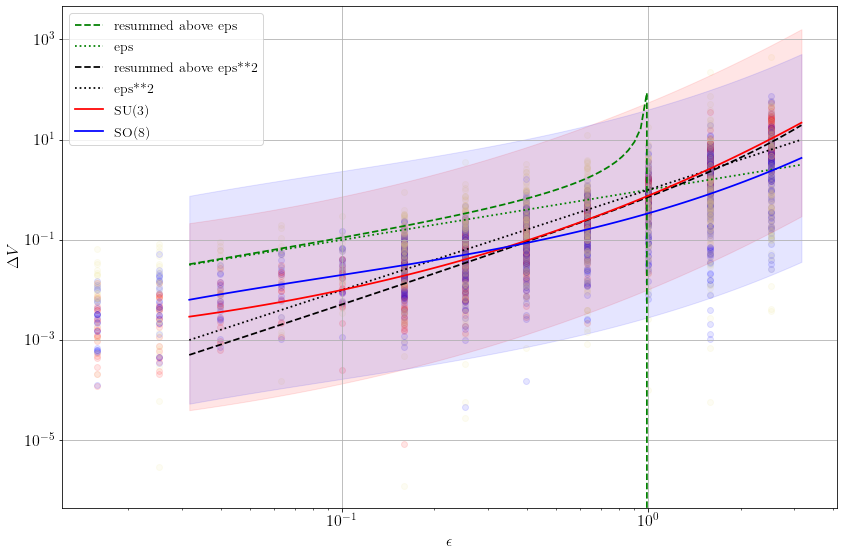

In [247]:
fig,ax = plt.subplots(1,figsize=(12,8))
ax.scatter(epses,np.abs(transVdiffs),color="red", alpha=0.1)
ax.scatter(epses,np.abs(rotVdiffs),color="blue", alpha=0.1)
ax.scatter(epses,np.abs(shiftVdiffs),color="khaki", alpha=0.1)
ax.set_xlabel(r'$\epsilon$')
ax.set_ylabel(r'$\Delta V$')
ax.set_xscale('log')
ax.set_yscale('log')

x = np.logspace(-1.5,0.5,100)
y1 = np.exp(x)-(1+x)
y = 1/(1-x)-(1)
ax.plot(x,y,color="green",linestyle='--',label='resummed above eps')
ax.plot(x,x,color="green",linestyle='dotted',label='eps')
ax.plot(x,y1,color="black",linestyle='--',label='resummed above eps**2')
ax.plot(x,x**2,color="black",linestyle='dotted',label='eps**2')


polyfsu3=np.polyfit(x=np.log(epses.astype(float)), y=np.log(abs(transVdiffs).astype(float)), deg=3)
psu3 = np.polynomial.polynomial.Polynomial(polyfsu3[::-1])
ax.plot(x,np.exp(psu3(np.log(x))), color="red",label='SU(3)')
diffs=np.zeros(number_predictions)
for i in range(number_predictions):
    difs = np.exp(psu3(np.log(epses[i])))-np.abs(transVdiffs[i])
    diffs[i] = difs/np.abs(transVdiffs[i])
su3sd=np.std(diffs)
ax.fill_between(x,1/su3sd*np.exp(psu3(np.log(x))),su3sd*np.exp(psu3(np.log(x))), color="red", alpha=0.1)

polyfrot=np.polyfit(x=np.log(epses.astype(float)), y=np.log(abs(rotVdiffs).astype(float)), deg=3)
prot = np.polynomial.polynomial.Polynomial(polyfrot[::-1])
ax.plot(x,np.exp(prot(np.log(x))), color="blue",label='SO(8)')
diffs=np.zeros(number_predictions)
for i in range(number_predictions):
    difs = np.exp(psu3(np.log(epses[i])))-np.abs(rotVdiffs[i])
    diffs[i] = difs/np.abs(rotVdiffs[i])
rotsd=np.std(diffs)
ax.fill_between(x,1/rotsd*np.exp(prot(np.log(x))),rotsd*np.exp(prot(np.log(x))), color="blue", alpha=0.1)


transeps=np.column_stack(((np.log10(epses)).round(1),(np.log10(np.abs(transVdiffs))).round(1)))
dfepses = pd.DataFrame(data=transeps, columns=["eps", "su3"])
sb.lineplot(data=dfepses, x="eps", y="su3")

plt.yscale('log')
plt.xscale('log')
plt.grid()

ax.legend()
fig.tight_layout()
# fig.savefig('DeltaV.png',dpi=200,transparent=False)

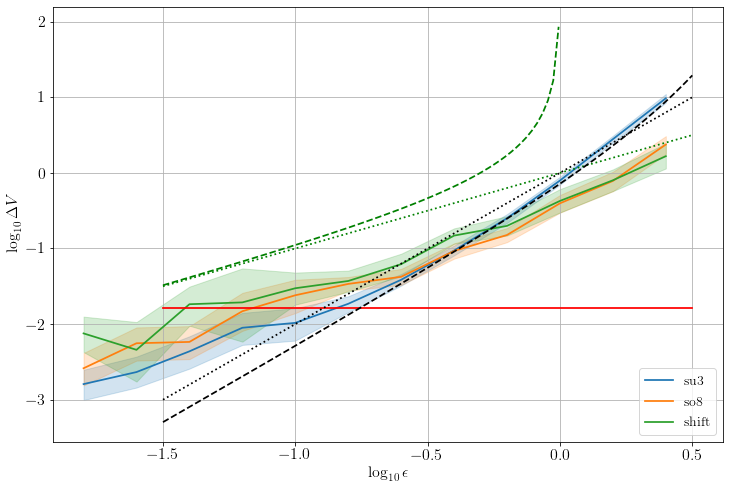

In [256]:
fig = plt.figure(figsize=(12,8))

transeps=np.column_stack(((np.log10(epses)),(np.log10(np.abs(transVdiffs))),(np.log10(np.abs(rotVdiffs))),
                          (np.log10(np.abs(shiftVdiffs)))))
dfepses = pd.DataFrame(data=transeps, columns=["eps", "su3", "so8", "shift"])
sb.lineplot(data=dfepses, x="eps", y="su3")
sb.lineplot(data=dfepses, x="eps", y="so8")
sb.lineplot(data=dfepses, x="eps", y="shift")
plt.legend(title='', loc='lower right', labels=['su3', 'so8', "shift"])
plt.grid()
plt.xlabel(r'$\log_{10}\epsilon$')
plt.ylabel(r'$\log_{10}\Delta V$')

x = np.linspace(-1.5,0.5,100)
lastlossx= np.log10((hist.history)['val_loss'][-1]*0.01)+0*x
plt.plot(x,lastlossx,color="red",linestyle='-',label='loss')

y1 = np.log10(np.exp(10**x)-(1+10**x))
y = np.log10(1/(1-10**x)-(1))
plt.plot(x,y,color="green",linestyle='--',label='resummed above eps')
plt.plot(x,x,color="green",linestyle='dotted',label='eps')
plt.plot(x,y1,color="black",linestyle='--',label='resummed above eps**2')
plt.plot(x,2*x,color="black",linestyle='dotted',label='eps**2')

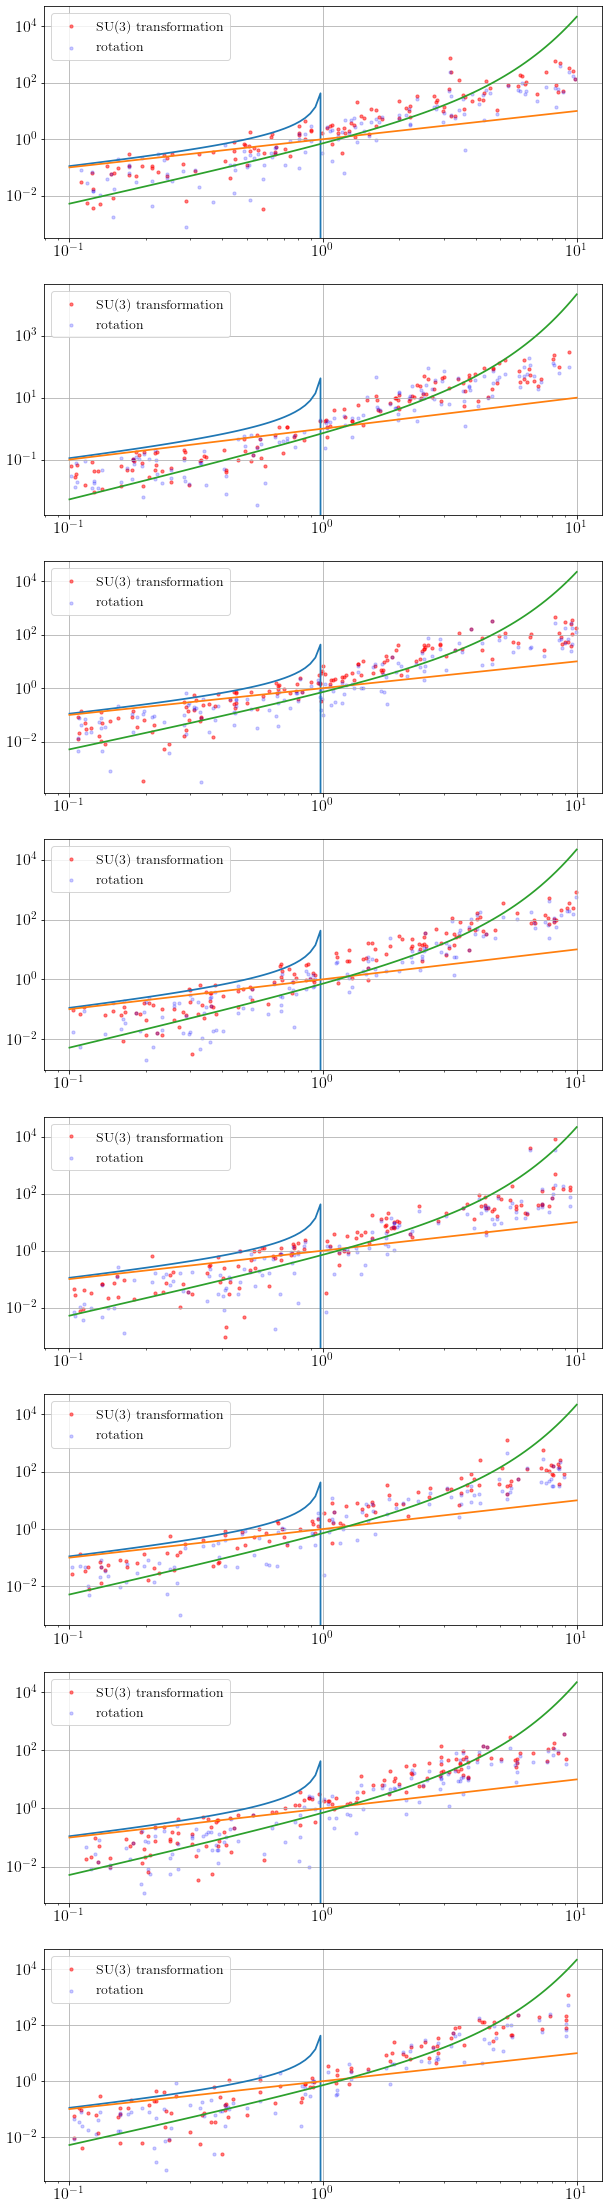

In [33]:
f, axs = plt.subplots(8,1, figsize=(10,40))

clear_output(wait=True)

y1 = np.exp(x)-(1+x)
y = 1/(1-x)-1


for gno in range(8):
    axs[gno].scatter(epses[np.where(gennos == gno)],abs(transVdiffs[np.where(gennos == gno)]), color="red", s=10, alpha=0.5, label ="SU(3) transformation")
    axs[gno].scatter(epses[np.where(gennos == gno)],abs(rotVdiffs[np.where(gennos == gno)]), color="blue", s=10, alpha=0.2, label="rotation")

    axs[gno].set_yscale('log')
    axs[gno].set_xscale('log')
    
    axs[gno].plot(x,y)
    axs[gno].plot(x,x)
    axs[gno].plot(x,y1)
    
    axs[gno].legend()
    axs[gno].grid()